# Granite models

In [ ]:
# Standard
import os
import math
import tempfile

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed, PatchTSTConfig, PatchTSTForPrediction
import numpy as np
import pandas as pd
import torch

# Local
from tsfm_public.toolkit.visualization import plot_predictions
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback
from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index
from tsfm_public import count_parameters

## TTM

In [ ]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

DATA_ROOT_PATH = "/content/drive/MyDrive/Colab Notebooks/records.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"

# Forecasting parameters
context_length = 512
forecast_length = 96
fewshot_fraction = 0.05

In [ ]:
df_tmp = pd.read_csv(DATA_ROOT_PATH)

# Llenar o eliminar valores nulos
# Llenar valores nulos con la media (puedes elegir otra estrategia)
df_tmp.fillna({'carbs': 0, 'insulin': 0, 'duration': 0}, inplace=True)
df_tmp.dropna(subset=['sgv'], inplace=True)

df_tmp

,created_at,sgv,carbs,insulin,duration
0,2024-04-01 00:00:00+00:00,158.0,0.0,0.0,0.0
1,2024-04-01 00:05:00+00:00,158.0,0.0,0.0,0.0
2,2024-04-01 00:10:00+00:00,159.0,0.0,0.0,0.0
3,2024-04-01 00:15:00+00:00,162.0,0.0,0.0,0.0
4,2024-04-01 00:20:00+00:00,163.0,0.0,0.0,0.0
...,...,...,...,...,...
33314,2024-08-01 15:50:00+00:00,101.0,0.0,0.0,0.0
33315,2024-08-01 15:55:00+00:00,95.0,0.0,0.0,0.0
33316,2024-08-01 16:00:00+00:00,90.0,0.0,0.0,0.0
33317,2024-08-01 16:05:00+00:00,85.0,0.0,0.0,0.0


<Axes: xlabel='created_at'>

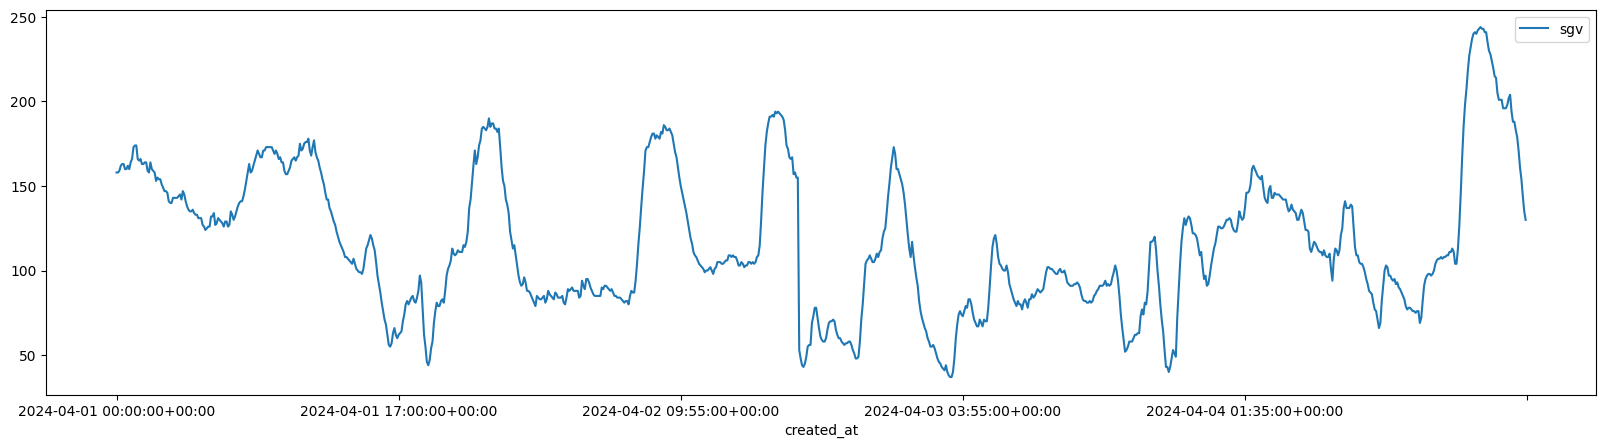

In [ ]:
df_tmp.iloc[:1000].plot(x="created_at", y="sgv", figsize=(20,5))

In [ ]:
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

dataset_path = DATA_ROOT_PATH
timestamp_column = "created_at"
id_columns = []
target_columns = ["sgv", "carbs", "insulin", "duration"]
split_config = {
                "train": [0, 20000],
                "valid": [20000, 30000],
                "test": [30000, 33194],
            }
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
    data, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

Data lengths: train = 879, val = 9905, test = 3099


<ipython-input-6-6e7ed16213a5>:35: DeprecationWarning: Call to deprecated method get_datasets. (Please use the standalone function `get_datasets()`.) -- Deprecated since version 0.1.1.
  train_dataset, valid_dataset, test_dataset = tsp.get_datasets(


### Zero-shot evaluation method

#### Full forecast horizon

In [ ]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION)

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.24M [00:00<?, ?B/s]

In [ ]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    )
)

In [ ]:
zeroshot_trainer.evaluate(test_dataset)

{'eval_loss': 0.26934805512428284,
 'eval_runtime': 5.7556,
 'eval_samples_per_second': 538.433,
 'eval_steps_per_second': 8.513}

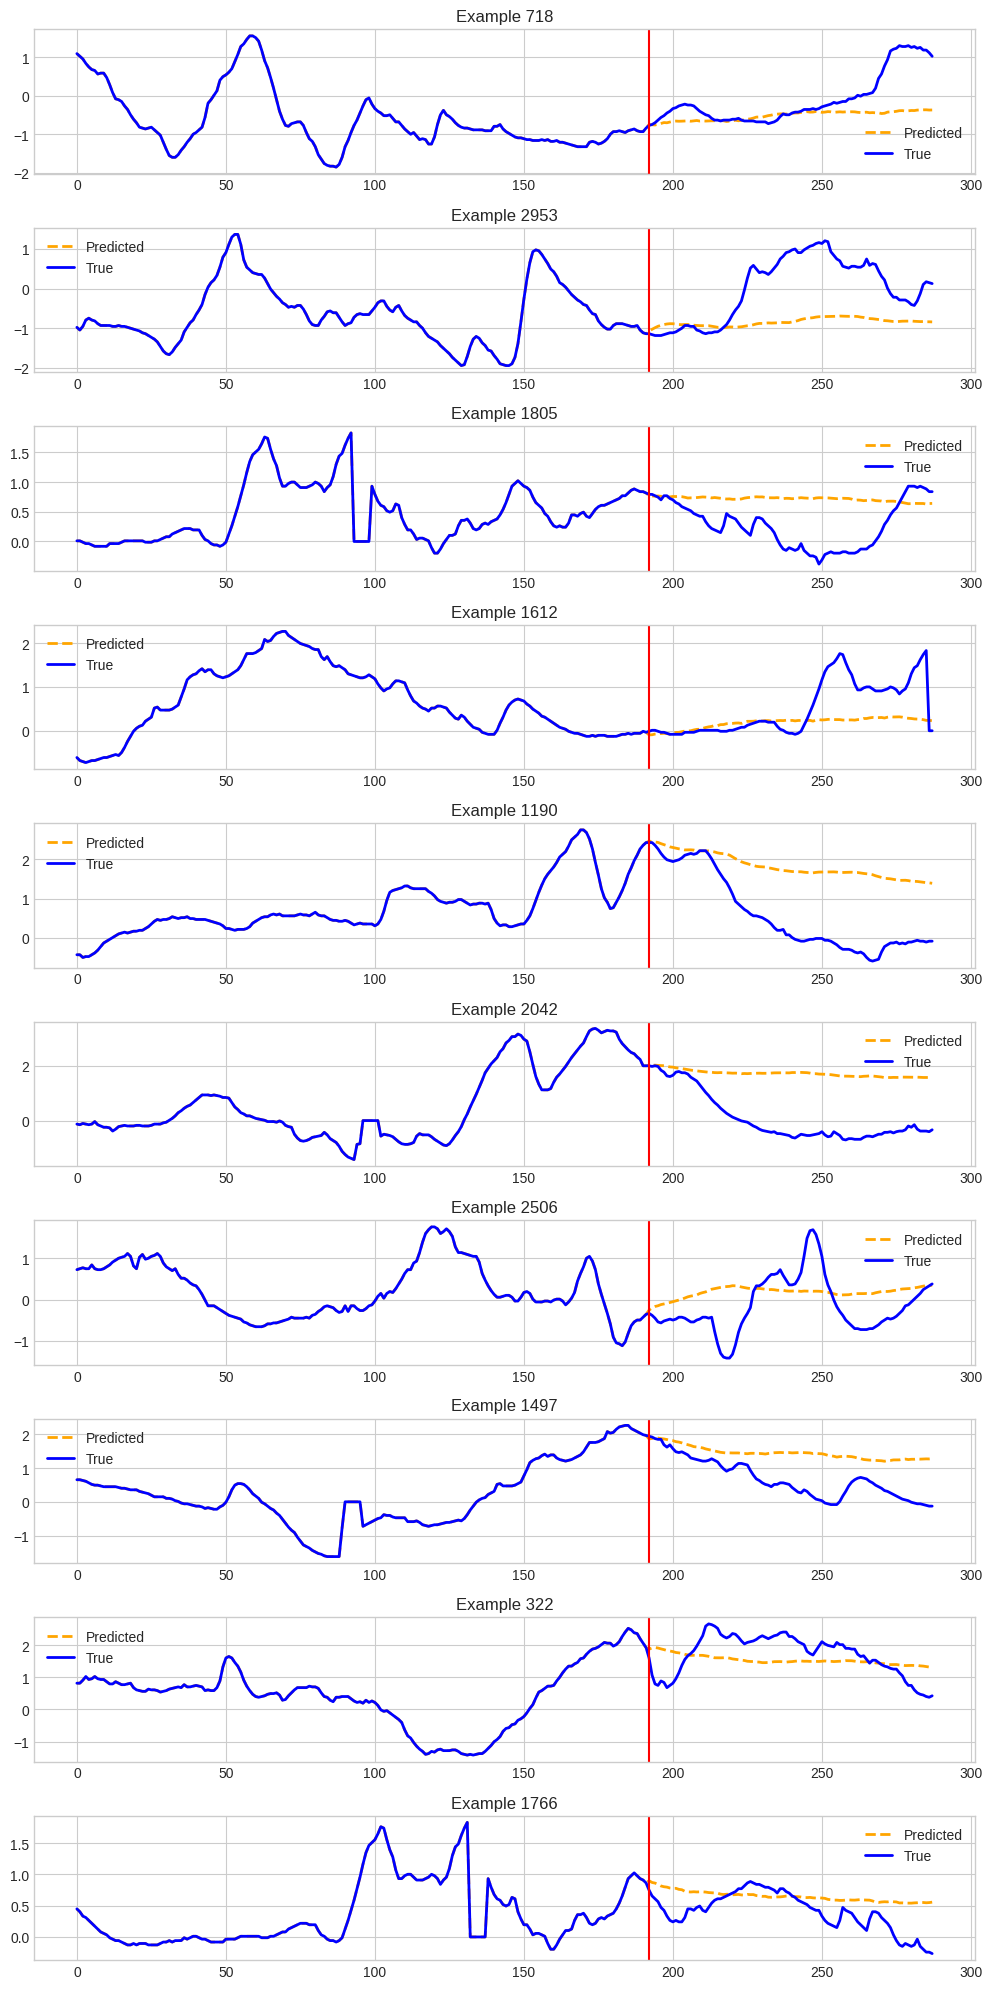

In [ ]:
plot_predictions(model=zeroshot_trainer.model, dset=test_dataset, plot_dir=os.path.join(OUT_DIR, "records"), plot_prefix="test_zeroshot", channel=0)

#### Trucated forecast horizon

In [ ]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm-granite/granite-timeseries-ttm-v1",
                                                            revision=TTM_MODEL_REVISION,prediction_filter_length=36)

In [ ]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    )
)

In [ ]:
zeroshot_trainer.evaluate(test_dataset)

{'eval_loss': 0.16902689635753632,
 'eval_runtime': 2.1544,
 'eval_samples_per_second': 1438.457,
 'eval_steps_per_second': 22.744}

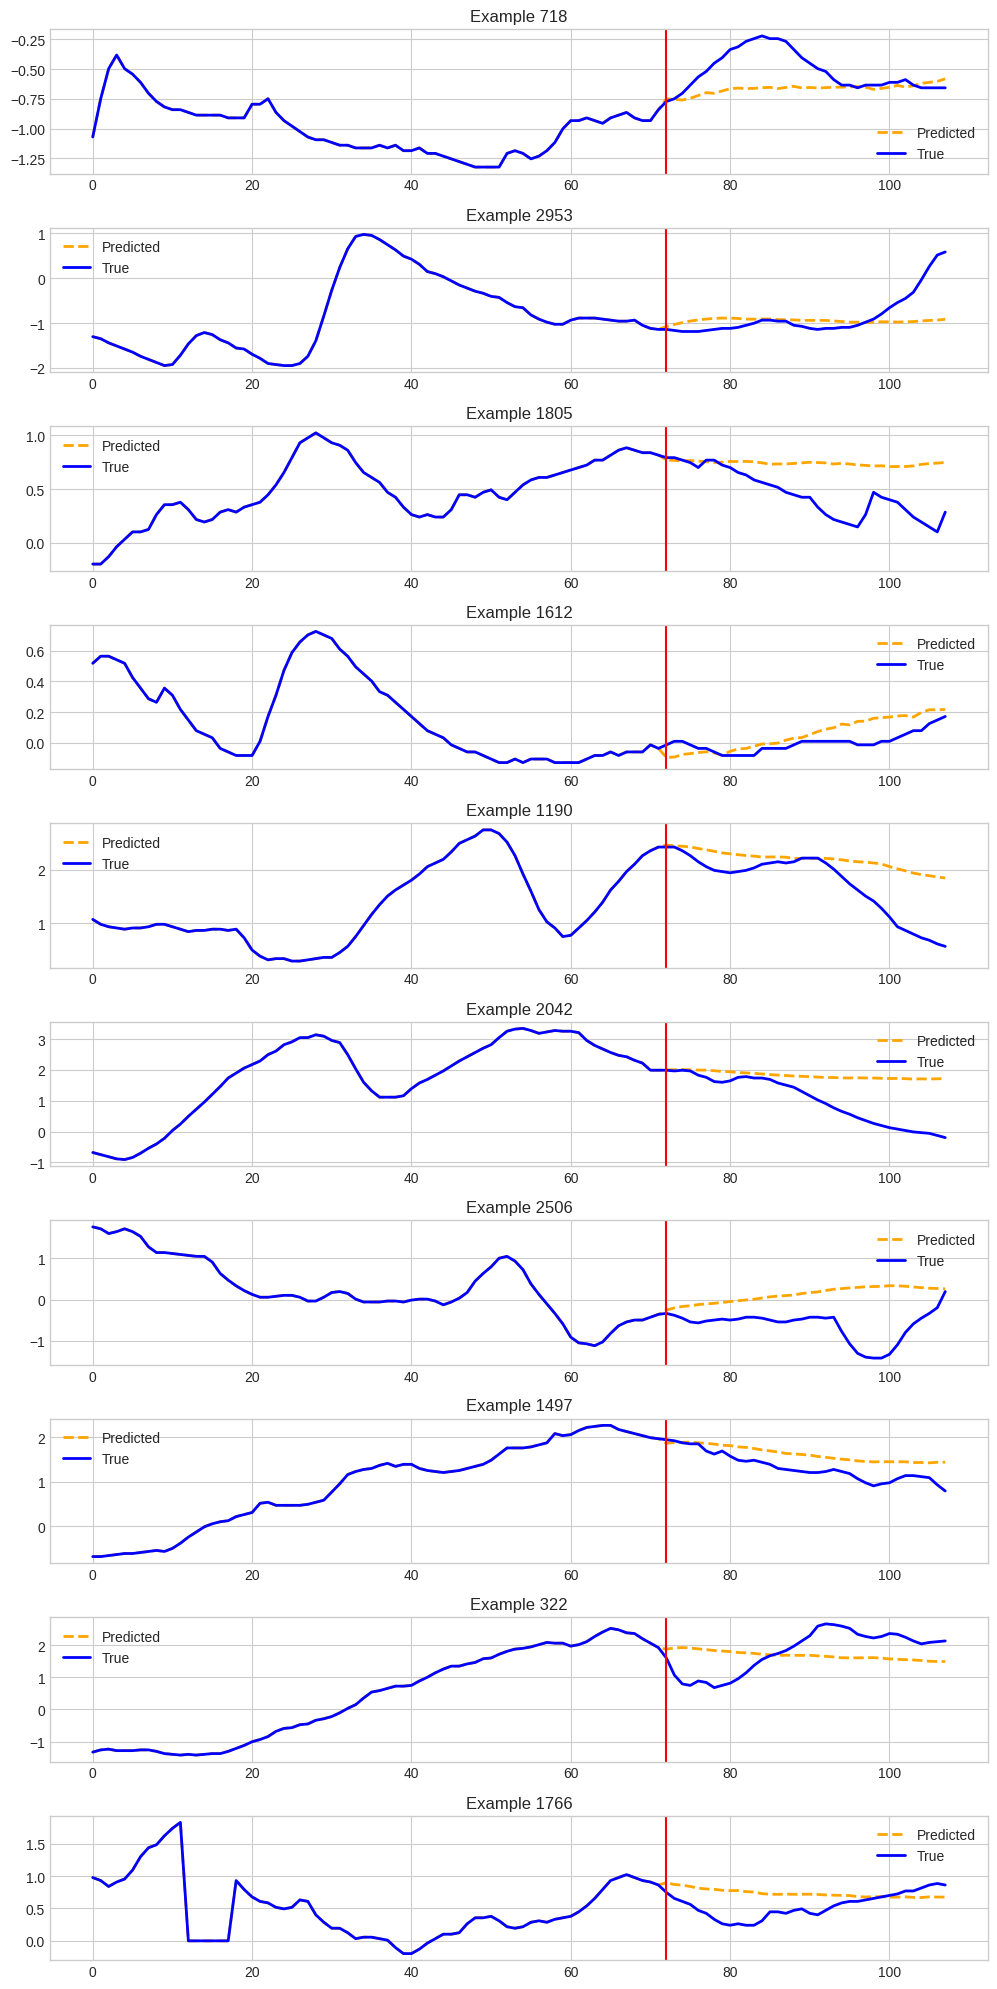

In [ ]:
plot_predictions(model=zeroshot_trainer.model, dset=test_dataset, plot_dir=os.path.join(OUT_DIR, "records"), plot_prefix="test_zeroshot", channel=0)

### Few-shot

#### Full forecast horizon

In [ ]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained("ibm-granite/granite-timeseries-ttm-v1",
                                                                     revision=TTM_MODEL_REVISION, head_dropout=0.7)

In [ ]:
print("Number of params before freezing backbone",
        count_parameters(finetune_forecast_model))

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print("Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model))

Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696


In [ ]:
# Important parameters
learning_rate = 0.001
num_epochs = 5
batch_size = 64

In [ ]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

Using learning rate = 0.001


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch,Training Loss,Validation Loss
1,0.457300,0.300107
2,0.290000,0.279468
3,0.190900,0.270252
4,0.165000,0.268479
5,0.161000,0.268433


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: Runtime

[TrackingCallback] Mean Epoch Time = 1.324153518676758 seconds, Total Train Time = 41.18601846694946


TrainOutput(global_step=70, training_loss=0.25281516143253874, metrics={'train_runtime': 41.19, 'train_samples_per_second': 106.701, 'train_steps_per_second': 1.699, 'total_flos': 43489758412800.0, 'train_loss': 0.25281516143253874, 'epoch': 5.0})

In [ ]:
finetune_forecast_trainer.evaluate(test_dataset)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'eval_loss': 0.2266041338443756,
 'eval_runtime': 2.3157,
 'eval_samples_per_second': 1338.249,
 'eval_steps_per_second': 21.16,
 'epoch': 5.0}

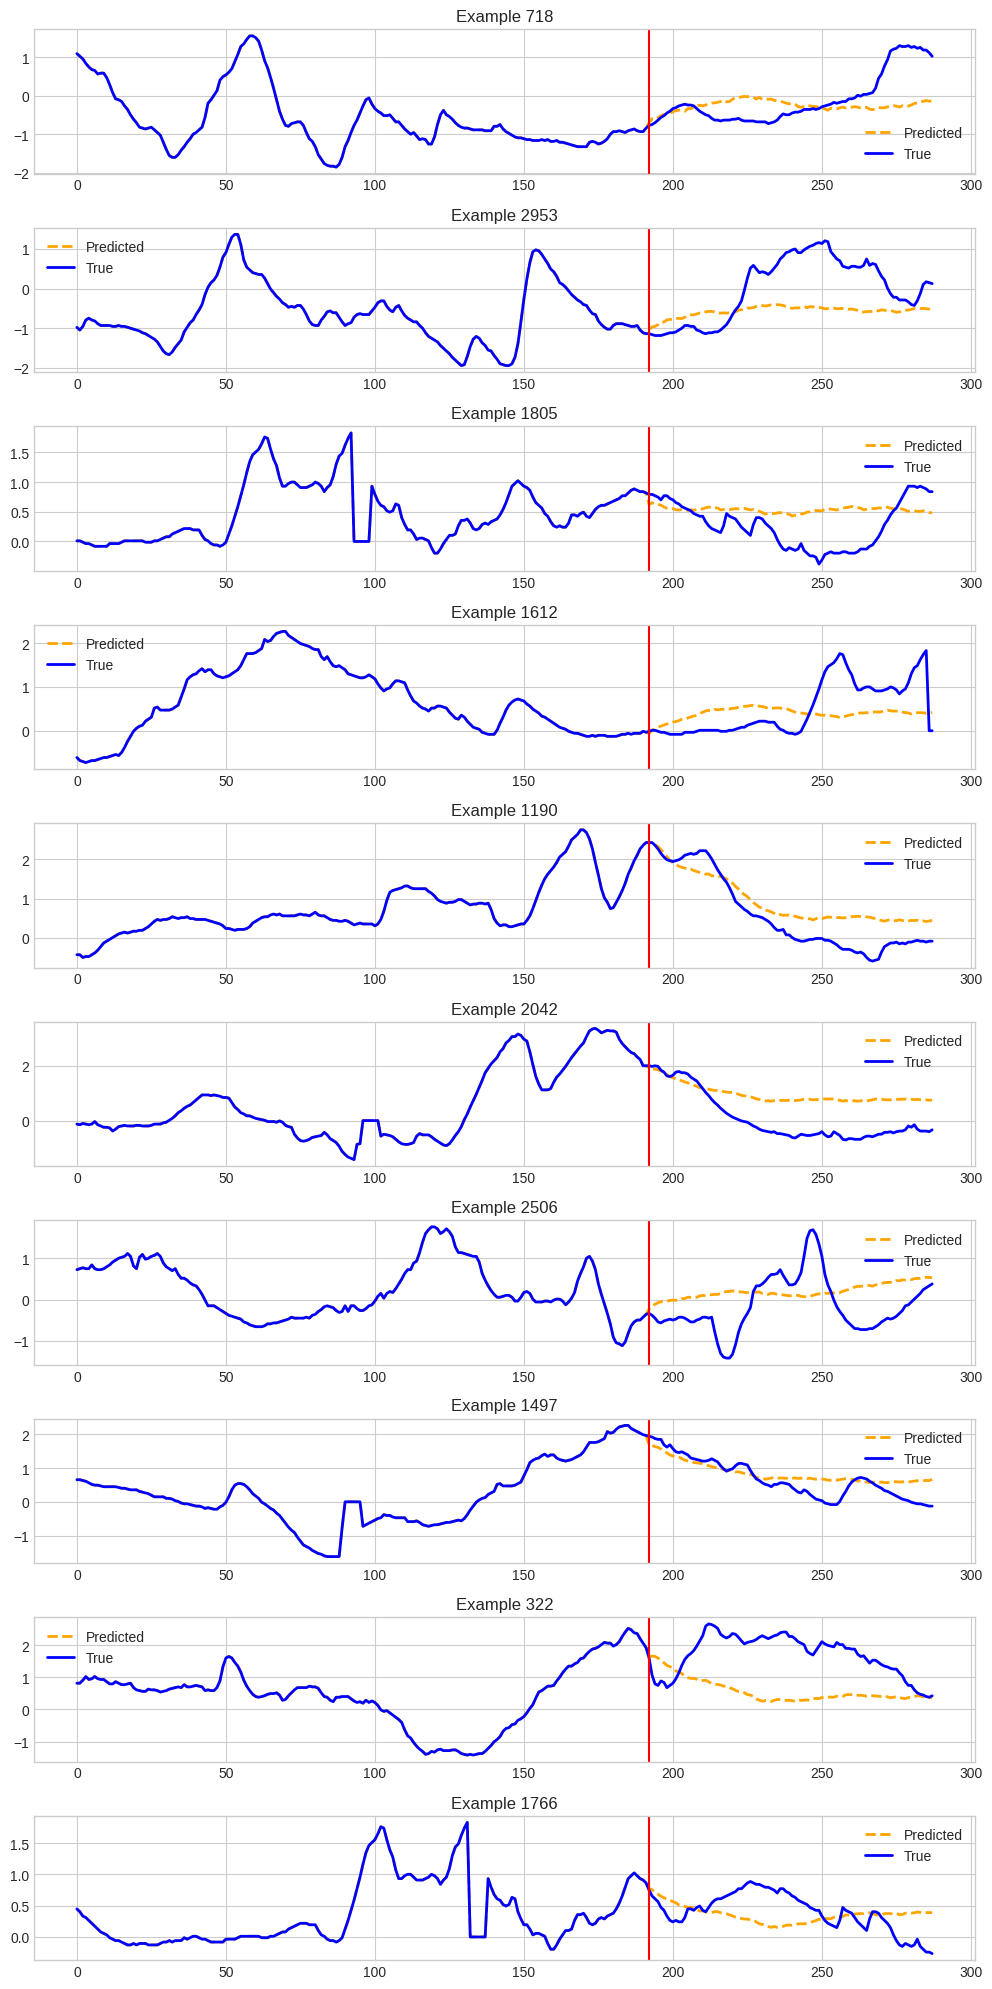

In [ ]:
plot_predictions(model=finetune_forecast_trainer.model, dset=test_dataset, plot_dir=os.path.join(OUT_DIR, "records"), plot_prefix="test_finetune", channel=0)

#### Truncated forecast horizon

In [ ]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained("ibm-granite/granite-timeseries-ttm-v1",
                                                                     revision=TTM_MODEL_REVISION, head_dropout=0.7,
                                                                     prediction_filter_length=36)

In [ ]:
print("Number of params before freezing backbone",
        count_parameters(finetune_forecast_model))

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print("Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model))

Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696


In [ ]:
# Important parameters
learning_rate = 0.001
num_epochs = 5
batch_size = 64

In [ ]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

Using learning rate = 0.001


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch,Training Loss,Validation Loss
1,0.350100,0.213413
2,0.238800,0.204973
3,0.157400,0.202078
4,0.138200,0.201564
5,0.131000,0.201704


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: Runtime

[TrackingCallback] Mean Epoch Time = 1.3366700172424317 seconds, Total Train Time = 42.403547286987305


TrainOutput(global_step=70, training_loss=0.20310837371008736, metrics={'train_runtime': 42.4067, 'train_samples_per_second': 103.639, 'train_steps_per_second': 1.651, 'total_flos': 43489758412800.0, 'train_loss': 0.20310837371008736, 'epoch': 5.0})

In [ ]:
finetune_forecast_trainer.evaluate(test_dataset)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'eval_loss': 0.15653899312019348,
 'eval_runtime': 1.9829,
 'eval_samples_per_second': 1562.851,
 'eval_steps_per_second': 24.711,
 'epoch': 5.0}

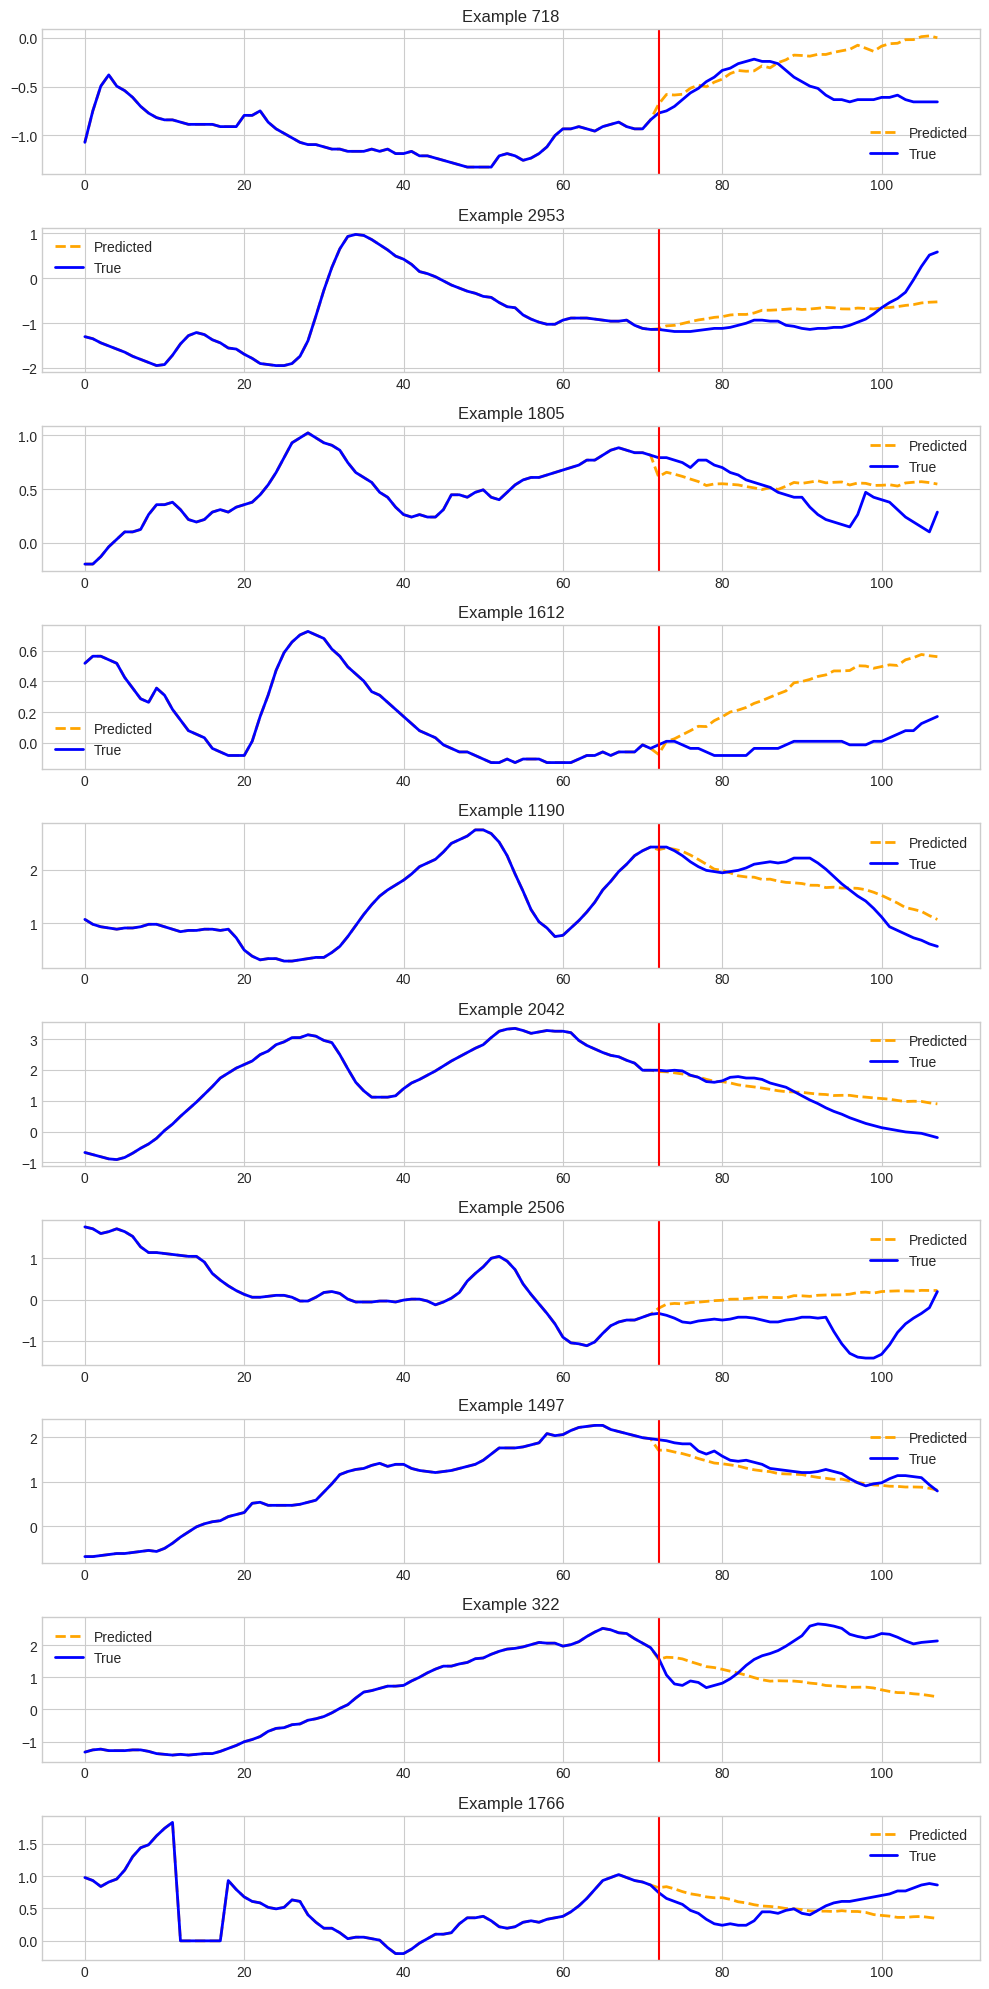

In [ ]:
plot_predictions(model=finetune_forecast_trainer.model, dset=test_dataset, plot_dir=os.path.join(OUT_DIR, "records"), plot_prefix="test_finetune", channel=0)